In [3]:
from datetime import datetime, timedelta, date, time
from dateutil.relativedelta import relativedelta
from pprint import pprint
import json
import requests
import numpy as np
import pandas as pd

from src.params import *
from src.nws import NWSClient
from src.nws import (
    fahrenheit_to_celsius,
    celsius_to_fahrenheit,
    load_one_minutes,
    parse_one_minute_path,
    has_date_intersection,
    one_minute_path
)
from src.file_utils import glob

In [6]:
import numpy as np
import math

def f(x):
    return (2 * np.sqrt(2 - x) - math.pi* np.sqrt(x) + 2 * np.sqrt(x) * np.arcsin(np.sqrt(x)/np.sqrt(2)))/((2 - x)**(3/2))

/tmp/ipykernel_204952/1091132694.py:5: RuntimeWarning: invalid value encountered in sqrt
  return (2 * np.sqrt(2 - x) - math.pi* np.sqrt(x) + 2 * np.sqrt(x) * np.arcsin(np.sqrt(x)/np.sqrt(2)))/((2 - x)**(3/2))
/tmp/ipykernel_204952/1091132694.py:5: RuntimeWarning: invalid value encountered in arcsin
  return (2 * np.sqrt(2 - x) - math.pi* np.sqrt(x) + 2 * np.sqrt(x) * np.arcsin(np.sqrt(x)/np.sqrt(2)))/((2 - x)**(3/2))
/tmp/ipykernel_204952/1091132694.py:5: RuntimeWarning: invalid value encountered in power
  return (2 * np.sqrt(2 - x) - math.pi* np.sqrt(x) + 2 * np.sqrt(x) * np.arcsin(np.sqrt(x)/np.sqrt(2)))/((2 - x)**(3/2))


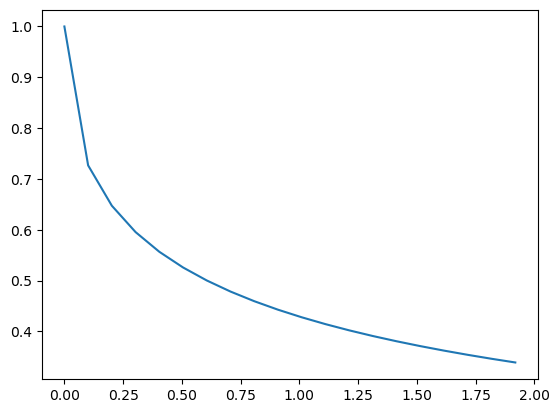

In [7]:
x = np.linspace(0, 10, 100)
y = f(x)

import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()

In [9]:
f(3)

/tmp/ipykernel_204952/1091132694.py:5: RuntimeWarning: invalid value encountered in sqrt
  return (2 * np.sqrt(2 - x) - math.pi* np.sqrt(x) + 2 * np.sqrt(x) * np.arcsin(np.sqrt(x)/np.sqrt(2)))/((2 - x)**(3/2))
/tmp/ipykernel_204952/1091132694.py:5: RuntimeWarning: invalid value encountered in arcsin
  return (2 * np.sqrt(2 - x) - math.pi* np.sqrt(x) + 2 * np.sqrt(x) * np.arcsin(np.sqrt(x)/np.sqrt(2)))/((2 - x)**(3/2))


np.complex128(nan+nanj)

In [3]:

station = StationID.MIA
params = {
    "station": str(station),
    "vars": "tmpf",
    "sts": STATION_TZ[station].localize(datetime(2024, 11, 15, 0, 0, 0)).astimezone(pytz.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
    "ets": STATION_TZ[station].localize(datetime(2024, 11, 15, 23, 59, 59)).astimezone(pytz.utc).strftime("%Y-%m-%dT%H:%M:%SZ"),
    "sample": "1min",
    "what": "view",
    "tz": "UTC",
}

print(ONE_MINUTE_BASE.with_query(params))

https://mesonet.agron.iastate.edu/cgi-bin/request/asos1min.py?ets=2024-11-16T04%3A59%3A59Z&sample=1min&station=MIA&sts=2024-11-15T05%3A00%3A00Z&tz=UTC&vars=tmpf&what=view


In [2]:
fp = TMP_DIR / "AUS" / "one_minute.AUS.start-2005-02-09T03-35-00.end-2005-02-28T23-59-00.csv"
path_parse = parse_one_minute_path(fp)
pprint(path_parse)

OneMinutePathParse(station=<StationID.AUS: 'AUS'>,
                   start=datetime.datetime(2005, 2, 9, 3, 35, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>),
                   end=datetime.datetime(2005, 2, 28, 23, 59, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>),
                   output_dir=PosixPath('../tmp'),
                   path=PosixPath('../tmp/AUS/one_minute.AUS.start-2005-02-09T03-35-00.end-2005-02-28T23-59-00.csv'))


In [3]:
one_minute_pattern = one_minute_path(station=path_parse.station, output_dir=path_parse.output_dir)
print(one_minute_pattern)
one_minute_paths = glob(one_minute_pattern)
print(one_minute_paths)
print(len(one_minute_paths))

../tmp/AUS/one_minute.AUS.start-*.end-*.csv
[PosixPath('../tmp/AUS/one_minute.AUS.start-2005-02-09T03-35-00.end-2005-02-28T23-59-00.csv')]
1


In [4]:
has_date_intersection(
    start1=path_parse.start,
    end1=path_parse.end,
    start2=path_parse.start,
    end2=path_parse.end,
)

True

In [7]:
df = load_one_minutes(
    station=path_parse.station,
    start=path_parse.start,
    end=path_parse.end,
    output_dir=path_parse.output_dir,
)

print(len(df))
display(df.head(25))

[PosixPath('../tmp/AUS/one_minute.AUS.start-2005-02-09T03-35-00.end-2005-02-28T23-59-00.csv')]
{'na_values': ['M']}


/home/abhmul/dev/kalshi-arbitrage/src/pd_utils.py:68: UserWarning: Instantiating StringDtype without any arguments.Pass a StringDtype instance to silence this warning.
  df = pd.read_csv(path, dtype=filtered_schema, **kwargs)
/home/abhmul/dev/kalshi-arbitrage/src/pd_utils.py:68: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  df = pd.read_csv(path, dtype=filtered_schema, **kwargs)
/home/abhmul/dev/kalshi-arbitrage/src/pd_utils.py:68: UserWarning: Instantiating StringDtype without any arguments.Pass a StringDtype instance to silence this warning.
  df = pd.read_csv(path, dtype=filtered_schema, **kwargs)
/home/abhmul/dev/kalshi-arbitrage/src/pd_utils.py:68: UserWarning: Instantiating Int64Dtype without any arguments.Pass a Int64Dtype instance to silence this warning.
  df = pd.read_csv(path, dtype=filtered_schema, **kwargs)


27991


,station,station_name,tmpf,valid
0,AUS,Austin Bergstrom Intl,<NA>,2005-02-09 03:35:00-06:00
1,AUS,Austin Bergstrom Intl,<NA>,2005-02-09 03:36:00-06:00
2,AUS,Austin Bergstrom Intl,<NA>,2005-02-09 03:37:00-06:00
3,AUS,Austin Bergstrom Intl,<NA>,2005-02-09 03:38:00-06:00
4,AUS,Austin Bergstrom Intl,<NA>,2005-02-09 03:39:00-06:00
5,AUS,Austin Bergstrom Intl,54,2005-02-09 03:40:00-06:00
6,AUS,Austin Bergstrom Intl,55,2005-02-09 03:41:00-06:00
7,AUS,Austin Bergstrom Intl,55,2005-02-09 03:42:00-06:00
8,AUS,Austin Bergstrom Intl,55,2005-02-09 03:43:00-06:00
9,AUS,Austin Bergstrom Intl,54,2005-02-09 03:44:00-06:00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27991 entries, 0 to 27990
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype                    
---  ------        --------------  -----                    
 0   station       27991 non-null  object                   
 1   station_name  27991 non-null  string                   
 2   tmpf          27981 non-null  Int64                    
 3   valid         27991 non-null  datetime64[ns, UTC-06:00]
dtypes: Int64(1), datetime64[ns, UTC-06:00](1), object(1), string(1)
memory usage: 902.2+ KB


In [8]:
from glob import glob

list(glob(str(CLI_OBSERVATIONS / "MIA" / "*.txt")))

['../data/inputs/cli/MIA/cli.MIA.issued-2024-10-25T04-25-00.summary-2024-10-24.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-11-11T16-22-00.summary-2024-11-11.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-11-13T04-24-00.summary-2024-11-12.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-11-09T16-22-00.summary-2024-11-09.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-11-14T16-22-00.summary-2024-11-14.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-11-03T04-21-00.summary-2024-11-02.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-10-22T04-22-00.summary-2024-10-21.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-10-24T16-21-00.summary-2024-10-24.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-11-06T16-21-00.summary-2024-11-06.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-11-11T04-21-00.summary-2024-11-10.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-10-23T16-40-00.summary-2024-10-23.txt',
 '../data/inputs/cli/MIA/cli.MIA.issued-2024-10-29T04-21-00.summa

In [32]:
pd.concat([pd.DataFrame(), pd.DataFrame(np.arange(10).reshape(5, 2))])

,0,1
0,0,1
1,2,3
2,4,5
3,6,7
4,8,9


In [29]:
pr = pd.period_range(start='2010-08',end='2011-03', freq='M')
display(pr)
pr[0].to_timestamp() + relativedelta(months=1)

PeriodIndex(['2010-08', '2010-09', '2010-10', '2010-11', '2010-12', '2011-01',
             '2011-02', '2011-03'],
            dtype='period[M]')

Timestamp('2010-09-01 00:00:00')

In [18]:
client = NWSClient()

station = StationID.MDW
start = STATION_TZ[station].localize(datetime(2024, 10, 1))
end = STATION_TZ[station].localize(datetime(2024, 11, 1))


one_min_res = client._request_one_minute_data(StationID.MDW, start=start, end=end)
one_min_res

<Response [200]>

In [19]:
import pandas as pd
from io import StringIO

df = pd.read_csv(StringIO(one_min_res.text), header=0)
df["valid(UTC)"] = pd.to_datetime(df["valid(UTC)"], utc=True)
df["valid(UTC)"] = df["valid(UTC)"].dt.tz_convert(STATION_TZ[station])

df.info()
display(df.head())
display(df["valid(UTC)"].min(), df["valid(UTC)"].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35183 entries, 0 to 35182
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype                          
---  ------        --------------  -----                          
 0   station       35183 non-null  object                         
 1   station_name  35183 non-null  object                         
 2   valid(UTC)    35183 non-null  datetime64[ns, America/Chicago]
 3   tmpf          35183 non-null  object                         
dtypes: datetime64[ns, America/Chicago](1), object(3)
memory usage: 1.1+ MB


,station,station_name,valid(UTC),tmpf
0,MDW,CHICAGO,2024-10-02 16:37:00-05:00,71
1,MDW,CHICAGO,2024-10-02 16:38:00-05:00,71
2,MDW,CHICAGO,2024-10-02 16:39:00-05:00,71
3,MDW,CHICAGO,2024-10-02 16:40:00-05:00,71
4,MDW,CHICAGO,2024-10-02 16:41:00-05:00,72


Timestamp('2024-10-02 16:37:00-0500', tz='America/Chicago')

Timestamp('2024-10-31 23:59:00-0500', tz='America/Chicago')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17472 entries, 0 to 17471
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station       17472 non-null  object        
 1   station_name  17472 non-null  object        
 2   valid(UTC)    17472 non-null  datetime64[ns]
 3   tmpf          17472 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 546.1+ KB


In [4]:
client = NWSClient()

cli_data = client.get_cli_data(StationID.AUS, version=3)
pprint(cli_data.without_raw_text())

CLI(issuance_time=datetime.datetime(2024, 11, 15, 7, 43, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>),
    issuing_office='EWX',
    summary_date=datetime.date(2024, 11, 15),
    raw_text='...',
    max_temp=46,
    max_temp_time=datetime.datetime(2024, 11, 15, 0, 14, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>),
    min_temp=37,
    min_temp_time=datetime.datetime(2024, 11, 15, 5, 21, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>),
    avg_temp=42,
    valid_time=datetime.datetime(2024, 11, 15, 7, 0, tzinfo=<DstTzInfo 'America/Chicago' CST-1 day, 18:00:00 STD>))


In [21]:
from dateutil import parser, tz

# datetime.strptime('0421 PM EST FRI NOV 15 2024', '%I%M %p %Z %a %b %d %Y')
# parser.parse('04:21 PM EST FRI NOV 15 2024', tzinfos={'EST': STATION_TZ[StationID.MIA]})dt
parser.parse("NOVEMBER 14 2024")

# datetime.strptime('0421 PM EST', '%I%M %p %Z')

datetime.datetime(2024, 11, 14, 0, 0)

In [ ]:
version=1)
cli_data.raw_text

In [15]:
temp_c = 30.5


print(f"{temp_c}°C = {celsius_to_fahrenheit(temp_c)}°F")

temp_f = 87.8

print(f"{temp_f}°F = {fahrenheit_to_celsius(temp_f)}°C")

30.5°C = 86.9°F
87.8°F = 31.0°C


In [9]:
lst = [1,2,3]
i = 0
a = lst[(i := i + 1)]
print(a)
print(i)

2
1


In [22]:
import plotly.express as px
import plotly.graph_objects as go

def hedge_formula(p_1, p_2, n_1, n_2):
    # If p_1 is correct
    res_1 = ((1 - p_1) * n_1 - p_2 * n_2) / (n_1 * p_1 + n_2 * p_2)
    # If p_2 is correct
    res_2 = - (p_1 * n_1 - (1 - p_2) * n_2) / (n_1 * p_1 + n_2 * p_2)

    return res_1, res_2

def expected_hedge_formula(p_1, p_2, n_1, n_2):
    res1, res2 = hedge_formula(p_1, p_2, n_1, n_2)
    return p_1 * res1 + p_2 * res2

n_1 = 72
n_2 = np.linspace(0, 150, 151)

# p_1 = np.linspace(0, 1.0, 10)
# p_2 = 1 - p_1
p_1 = 0.91
p_2 = 0.10

# res = [hedge_formula(p_1i, p_2i, n_1, n_2) for p_1i, p_2i in zip(p_1, p_2)]
res = hedge_formula(p_1, p_2, n_1, n_2)
eres = expected_hedge_formula(p_1, p_2, n_1, n_2)

fig = go.Figure()
fig.add_trace(go.Scatter(x=n_2, y=res[0],
                    mode='lines',
                    name='p1'))
fig.add_trace(go.Scatter(x=n_2, y=res[1],
                    mode='lines',
                    name='p2'))
fig.add_trace(go.Scatter(x=n_2, y=eres,
                    mode='lines',
                    name='expected'))

In [20]:
hedge_formula(0.91, 0.1,72, 30)

# 72 * 0.91 + 30 * 0.1

(0.0507880910683012, -0.5621716287215411)

In [33]:
client = NWSClient()
station = StationID.MDW
prior_days = 2

start = datetime.now(tz=BASE_TZ) - timedelta(days=prior_days)
end = datetime.now(tz=BASE_TZ)
# Try getting observation data
# res = client._request_observations(station, datetime.now(tz=BASE_TZ) - timedelta(days=prior_days), datetime.now(tz=BASE_TZ))
url = TIME_SERIES_BASE
params = {
    "radius": "kmdw,0",
    "start": start.astimezone(pytz.utc).strftime("%Y%m%d%H%M"),
    "end": end.astimezone(pytz.utc).strftime("%Y%m%d%H%M"),
    "vars": "air_temp,wind_speed,wind_direction,relative_humidity,air_temp_high_6_hour,air_temp_high_24_hour",
    "token": PUBLIC_TOKEN,
}
response = requests.get(url, params=params)
response.raise_for_status()
res = response.json()

print(res)
json.dump(res, fp=(open('../tmp/observations.json', 'w')))

{'STATION': [{'ID': '4981', 'STID': 'KMDW', 'NAME': 'Chicago, Chicago Midway Airport', 'ELEVATION': '617.0', 'LATITUDE': '41.78417', 'LONGITUDE': '-87.75528', 'STATUS': 'ACTIVE', 'MNET_ID': '1', 'STATE': 'IL', 'TIMEZONE': 'America/Chicago', 'ELEV_DEM': '610.2', 'DISTANCE': 0.0, 'PERIOD_OF_RECORD': {'start': '2002-08-14T00:00:00Z', 'end': '2024-11-14T02:48:00Z'}, 'UNITS': {'position': 'm', 'elevation': 'ft'}, 'SENSOR_VARIABLES': {'air_temp': {'air_temp_set_1': {}}, 'relative_humidity': {'relative_humidity_set_1': {}}, 'wind_speed': {'wind_speed_set_1': {}}, 'wind_direction': {'wind_direction_set_1': {}}, 'air_temp_high_6_hour': {'air_temp_high_6_hour_set_1': {}}, 'air_temp_high_24_hour': {'air_temp_high_24_hour_set_1': {}}}, 'OBSERVATIONS': {'date_time': ['2024-11-12T03:35:00Z', '2024-11-12T03:40:00Z', '2024-11-12T03:45:00Z', '2024-11-12T03:50:00Z', '2024-11-12T03:53:00Z', '2024-11-12T03:55:00Z', '2024-11-12T04:00:00Z', '2024-11-12T04:05:00Z', '2024-11-12T04:10:00Z', '2024-11-12T04:15:0

In [34]:
len(res["STATION"])

1

In [9]:
from urlpath import URL
import requests
from pprint import pprint

# url = URL("https://api.weather.gov/products/1eae2f39-8187-42ad-ab00-1f212b40a93a")
url = URL("https://api.weather.gov/products/9c5a3929-9e59-46df-b406-a1aae6ca946c")
station = "FNT"
url = URL(f"https://forecast.weather.gov/product.php?site=DTX&issuedby={station}&product=CLI&format=CI&version=1&glossary=0")

response = requests.get(url)
response.raise_for_status()
print(response.text, file=open("../tmp/cli.html", 'w'))

In [12]:
lines = response.text.splitlines()
for i in range(len(lines) - 3):
    match_start = (f"CLI{station}" in lines[i] and "CLIMATE REPORT" in lines[i+2] and "NATIONAL WEATHER SERVICE" in lines[i+3])
    if match_start:
        match_start_i = i
        print(i)
    match_end = "$$" in lines[i]
    if match_end:
        match_end_i = i
        print(i)

print("\n".join(lines[match_start_i:match_end_i+1]))

461
559
CLIFNT

CLIMATE REPORT
NATIONAL WEATHER SERVICE DETROIT/PONTIAC MI
430 PM EST TUE NOV 12 2024

...................................

...THE FLINT MI CLIMATE SUMMARY FOR NOVEMBER 12 2024...
VALID TODAY AS OF 0400 PM LOCAL TIME.

CLIMATE NORMAL PERIOD 1991 TO 2020
CLIMATE RECORD PERIOD 1921 TO 2024


WEATHER ITEM   OBSERVED TIME   RECORD YEAR NORMAL DEPARTURE LAST
                VALUE   (LST)  VALUE       VALUE  FROM      YEAR
                                                  NORMAL
...................................................................
TEMPERATURE (F)
 TODAY
  MAXIMUM         50        MM  68    1927  48      2       51
                                      1964
                                      2010
  MINIMUM         35        MM   6    2019  32      3       30
  AVERAGE         43                        40      3       41

PRECIPITATION (IN)
  TODAY            0.00          1.35 1992   0.08  -0.08     0.00
  MONTH TO DATE    0.54                      0.96  -0.

In [ ]:
from src.nws import NWSClient
from src.params import *
from datetime import datetime, timedelta

client = NWSClient()
res = client.get_timeseries(StationID.AUS, start=datetime.now() - timedelta(days=2), end=datetime.now())

res

In [ ]:
res["STATION"][0]["OBSERVATIONS"].keys()
res["STATION"][0]["OBSERVATIONS"]["air_temp_set_1"]

In [ ]:
from src.nws import NWSClient
from src.params import *

client = NWSClient()
client.get_all_cli_data(StationID.AUS)

In [ ]:
client.get_all_cli_data(StationID.AUS)


In [ ]:
from dataclasses import dataclass
from datetime import datetime, date
import re
from typing import Optional
from pprint import pprint

@dataclass
class ParsedCLIReport:
    issuance_time: datetime
    summary_date: date
    product_code: str
    product_name: str
    issuing_office: str
    max_temp: Optional[int] = None
    max_temp_time: Optional[datetime] = None
    min_temp: Optional[int] = None
    min_temp_time: Optional[datetime] = None
    avg_temp: Optional[int] = None
    precipitation: Optional[float] = None
    precipitation_month_to_date: Optional[float] = None
    precipitation_since_sep_1: Optional[float] = None
    precipitation_since_jan_1: Optional[float] = None
    highest_wind_speed: Optional[int] = None
    highest_wind_direction: Optional[str] = None
    highest_gust_speed: Optional[int] = None
    highest_gust_direction: Optional[str] = None
    average_wind_speed: Optional[float] = None
    average_sky_cover: Optional[float] = None
    highest_humidity: Optional[int] = None
    lowest_humidity: Optional[int] = None
    average_humidity: Optional[int] = None
    

def _parse_product_text(product_text: str, issuance_time: datetime, product_code: str, product_name: str, issuing_office: str) -> ParsedCLIReport:
    # Extract relevant sections using regular expressions

    date_match = re.search(r"THE AUSTIN BERGSTROM CLIMATE SUMMARY FOR (.+?)\.\.\.", product_text)

    temp_pattern = re.compile(r"""
        (MAXIMUM|MINIMUM|AVERAGE)\s+         # Match the label (MAXIMUM, MINIMUM, AVERAGE)
        (\d+)\s+                             # Match the observed value
        (\d{1,2}:\d{2}\s[APM]{2})?\s*        # Match the time (optional for AVERAGE)
        (\d+)?\s*                            # Match the record value (optional for AVERAGE)
        (\d{4})?\s*                          # Match the record year (optional for AVERAGE)
        (\d+)?\s*                            # Match the normal value (optional for AVERAGE)
        ([+-]?\d+)?\s*                       # Match the departure from normal (optional for AVERAGE)
        (\d+)?                               # Match the last year value (optional for AVERAGE)
    """, re.VERBOSE)

    matches = temp_pattern.findall(product_text)

    temp_data = {
        "max_temp": None,
        "max_temp_time": None,
        "min_temp": None,
        "min_temp_time": None,
        "avg_temp": None,
    }
    

    for match in matches:
        label, observed_value, time, *_ = match
        if label == "MAXIMUM":
            temp_data["max_temp"] = int(observed_value)
            if time:
                temp_data["max_temp_time"] = datetime.strptime(f"{date_match.group(1)} {time}", "%B %d %Y %I:%M %p")
        elif label == "MINIMUM":
            temp_data["min_temp"] = int(observed_value)
            if time:
                temp_data["min_temp_time"] = datetime.strptime(f"{date_match.group(1)} {time}", "%B %d %Y %I:%M %p")
        elif label == "AVERAGE":
            temp_data["avg_temp"] = int(observed_value)

    # precip_pattern = re.compile(r"""
    #     PRECIPITATION\s+\(IN\)\s+            # Match the PRECIPITATION header
    #     (?:.*?\n)+?                          # Non-greedy match to skip lines until labels
    #     (YESTERDAY|TODAY|MONTH TO DATE|SINCE SEP 1|SINCE JAN 1)\s+  # Match the label
    #     (\d+\.\d+)\s+                                         # Match the observed value
    #     (\d+\.\d+)?\s*                                        # Match the record value (optional)
    #     (\d{4})?\s*                                           # Match the record year (optional)
    #     (\d+\.\d+)?\s*                                        # Match the normal value (optional)
    #     ([+-]?\d+\.\d+)?\s*                                   # Match the departure from normal (optional)
    #     (\d+\.\d+)?                                           # Match the last year value (optional)
    # """, re.VERBOSE)

    # matches = precip_pattern.findall(product_text)

    # precipitation_data = {
    #     "day": None,
    #     "month_to_date": None,
    #     "since_sep_1": None,
    #     "since_jan_1": None
    # }

    # for match in matches:
    #     label, observed_value, *_ = match
    #     print(label, observed_value)
    #     if label == "YESTERDAY" or label == "TODAY":
    #         precipitation_data["day"] = float(observed_value)
    #     elif label == "MONTH TO DATE":
    #         precipitation_data["month_to_date"] = float(observed_value)
    #     elif label == "SINCE SEP 1":
    #         precipitation_data["since_sep_1"] = float(observed_value)
    #     elif label == "SINCE JAN 1":
    #         precipitation_data["since_jan_1"] = float(observed_value)

    highest_wind_speed_match = re.search(r"HIGHEST WIND SPEED\s+(\d+)", product_text)
    highest_wind_direction_match = re.search(r"HIGHEST WIND DIRECTION\s+(\w+)", product_text)
    highest_gust_speed_match = re.search(r"HIGHEST GUST SPEED\s+(\d+)", product_text)
    highest_gust_direction_match = re.search(r"HIGHEST GUST DIRECTION\s+(\w+)", product_text)
    average_wind_speed_match = re.search(r"AVERAGE WIND SPEED\s+(\d+\.\d+)", product_text)
    average_sky_cover_match = re.search(r"AVERAGE SKY COVER\s+(\d+\.\d+)", product_text)
    highest_humidity_match = re.search(r"HIGHEST\s+(\d+)", product_text)
    lowest_humidity_match = re.search(r"LOWEST\s+(\d+)", product_text)
    average_humidity_match = re.search(r"AVERAGE\s+(\d+)", product_text)

    # Convert date and time strings to date and datetime objects
    summary_date_obj = datetime.strptime(date_match.group(1), "%B %d %Y").date() if date_match else None

    return ParsedCLIReport(
        issuance_time=issuance_time,
        summary_date=summary_date_obj,
        max_temp=temp_data["max_temp"],
        max_temp_time=temp_data["max_temp_time"],
        min_temp=temp_data["min_temp"],
        min_temp_time=temp_data["min_temp_time"],
        avg_temp=temp_data["avg_temp"],
        # precipitation=precipitation_data["day"],
        # precipitation_month_to_date=precipitation_data["month_to_date"],
        # precipitation_since_sep_1=precipitation_data["since_sep_1"],
        # precipitation_since_jan_1=precipitation_data["since_jan_1"],
        highest_wind_speed=int(highest_wind_speed_match.group(1)) if highest_wind_speed_match else None,
        highest_wind_direction=highest_wind_direction_match.group(1) if highest_wind_direction_match else None,
        highest_gust_speed=int(highest_gust_speed_match.group(1)) if highest_gust_speed_match else None,
        highest_gust_direction=highest_gust_direction_match.group(1) if highest_gust_direction_match else None,
        average_wind_speed=float(average_wind_speed_match.group(1)) if average_wind_speed_match else None,
        average_sky_cover=float(average_sky_cover_match.group(1)) if average_sky_cover_match else None,
        highest_humidity=int(highest_humidity_match.group(1)) if highest_humidity_match else None,
        lowest_humidity=int(lowest_humidity_match.group(1)) if lowest_humidity_match else None,
        average_humidity=int(average_humidity_match.group(1)) if average_humidity_match else None,
        product_code=product_code,
        product_name=product_name,
        issuing_office=issuing_office
    )

def parse_json(json_data: dict) -> ParsedCLIReport:
    issuance_time = datetime.fromisoformat(json_data['issuanceTime'])
    product_code = json_data['productCode']
    product_name = json_data['productName']
    issuing_office = json_data['issuingOffice']
    product_text = json_data['productText']

    # print(product_text)
    parsed_report = _parse_product_text(product_text, issuance_time, product_code, product_name, issuing_office)

    return parsed_report

# Example usage
import requests

url = "https://api.weather.gov/products/1eae2f39-8187-42ad-ab00-1f212b40a93a"
response = requests.get(url)
response.raise_for_status()
data = response.json()

parsed_report = parse_json(data)
pprint(parsed_report)

In [ ]:
from datetime import datetime

product_text = """000
CDUS44 KEWX 112332
CLIAUS

CLIMATE REPORT 
NATIONAL WEATHER SERVICE AUSTIN/SAN ANTONIO
532 PM CST MON NOV 11 2024

...................................

...THE AUSTIN BERGSTROM CLIMATE SUMMARY FOR NOVEMBER 11 2024...
VALID TODAY AS OF 0500 PM LOCAL TIME.

CLIMATE NORMAL PERIOD: 1991 TO 2020
CLIMATE RECORD PERIOD: 1943 TO 2024


WEATHER ITEM   OBSERVED TIME   RECORD YEAR NORMAL DEPARTURE LAST      
                VALUE   (LST)  VALUE       VALUE  FROM      YEAR     
                                                  NORMAL           
...................................................................
TEMPERATURE (F)                                                          
 TODAY                                                               
  MAXIMUM         85   3:49 PM  87    2015  73     12       62        
  MINIMUM         54   7:01 AM  26    1950  48      6       54        
                                      2011                           
  AVERAGE         70                        61      9       58     

PRECIPITATION (IN)                                                    
  TODAY            0.00          1.91 1957   0.10  -0.10      T       
  MONTH TO DATE    1.37                      1.21   0.16     0.76     
  SINCE SEP 1      1.45                      8.49  -7.04     8.09     
  SINCE JAN 1     28.09                     31.49  -3.40    24.07     

SNOWFALL (IN)                                                              
  TODAY            0.0                                                
  MONTH TO DATE    0.0                                                
  SINCE SEP 1      0.0                                                
  SINCE JUL 1      0.0                                                
  SNOW DEPTH       0                                                 

DEGREE DAYS                                                           
 HEATING                                                              
  TODAY            0                         6     -6        7        
  MONTH TO DATE    6                        56    -50       52        
  SINCE SEP 1     13                       101    -88      104        
  SINCE JUL 1     13                       101    -88      104        

 COOLING                                                              
  TODAY            5                         2      3        0        
  MONTH TO DATE   89                        26     63       31        
  SINCE SEP 1    934                       644    290      903        
  SINCE JAN 1   3486                      2960    526     3477        
...................................................................


WIND (MPH)                                                            
  HIGHEST WIND SPEED     9   HIGHEST WIND DIRECTION    NE (50)        
  HIGHEST GUST SPEED    16   HIGHEST GUST DIRECTION     E (70)        
  AVERAGE WIND SPEED     2.9                                        


SKY COVER                                                             
  AVERAGE SKY COVER 0.1                                                 


WEATHER CONDITIONS                                                    
THE FOLLOWING WEATHER WAS RECORDED TODAY.                             
  NO SIGNIFICANT WEATHER WAS OBSERVED.                                  


RELATIVE HUMIDITY (PERCENT)
 HIGHEST    97           5:00 AM                                      
 LOWEST     41           5:00 PM                                      
 AVERAGE    69                                                        

..........................................................


THE AUSTIN BERGSTROM CLIMATE NORMALS FOR TOMORROW
                         NORMAL    RECORD    YEAR                     
 MAXIMUM TEMPERATURE (F)   73        87      1988                      
 MINIMUM TEMPERATURE (F)   48        26      1950                      


SUNRISE AND SUNSET                                                    
NOVEMBER 11 2024......SUNRISE   6:53 AM CST   SUNSET   5:36 PM CST     
NOVEMBER 12 2024......SUNRISE   6:54 AM CST   SUNSET   5:35 PM CST     


-  INDICATES NEGATIVE NUMBERS.
R  INDICATES RECORD WAS SET OR TIED.
MM INDICATES DATA IS MISSING.
T  INDICATES TRACE AMOUNT.




$$"""

lines = [l.strip() for l in product_text.splitlines()]

for line in lines:
    

issuance_time = datetime.strptime(lines[6], '%I%M %p %Z %a %b %d %Y')

summary_date_str = " ".join(lines[10].strip("...").split()[-3:])
summary_time_str = " ".join(lines[11].split()[-4:-2])
summary_datetime = datetime.strptime(f"{summary_date_str} {summary_time_str}", '%B %d %Y %I%M %p')

temp_max_details = lines[23].split()
temp_max = int(temp_max_details[1])
temp_max_time = datetime.strptime(" ".join(temp_max_details[2:4]), '%I:%M %p').time()
temp_min_details = lines[24].split()
temp_min = int(temp_min_details[1])
temp_min_time = datetime.strptime(" ".join(temp_min_details[2:4]), '%I:%M %p').time()

precip_day = float(lines[29].split()[1])
precip_month = float(lines[30].split()[1])
precip_ = float(lines[31].split()[1])

# print(" ".join(lines[10].strip("...").split(' ')[-3:]))
# summary_date = datetime.strptime(lines[10].split(' ')[-1], '%b %d %Y').date()

issuance_time, summary_datetime, temp_max, temp_max_time, temp_min, temp_min_time

In [ ]:
from dataclasses import dataclass
from datetime import datetime, date
from typing import Optional

@dataclass
class ParsedCLIReport:
    issuance_time: datetime
    summary_date: date
    product_code: str
    product_name: str
    issuing_office: str
    max_temp: Optional[int] = None
    max_temp_time: Optional[datetime] = None
    min_temp: Optional[int] = None
    min_temp_time: Optional[datetime] = None
    avg_temp: Optional[int] = None
    precipitation: Optional[float] = None
    precipitation_month_to_date: Optional[float] = None
    precipitation_since_sep_1: Optional[float] = None
    precipitation_since_jan_1: Optional[float] = None
    highest_wind_speed: Optional[int] = None
    highest_wind_direction: Optional[str] = None
    highest_gust_speed: Optional[int] = None
    highest_gust_direction: Optional[str] = None
    average_wind_speed: Optional[float] = None
    average_sky_cover: Optional[float] = None
    highest_humidity: Optional[int] = None
    lowest_humidity: Optional[int] = None
    average_humidity: Optional[int] = None

    ['000',
 'CDUS44 KEWX 112332',
 'CLIAUS',
 '',
 'CLIMATE REPORT ',
 'NATIONAL WEATHER SERVICE AUSTIN/SAN ANTONIO',
 '532 PM CST MON NOV 11 2024',
 '',
 '...................................',
 '',
 '...THE AUSTIN BERGSTROM CLIMATE SUMMARY FOR NOVEMBER 11 2024...',
 'VALID TODAY AS OF 0500 PM LOCAL TIME.',
 '',
 'CLIMATE NORMAL PERIOD: 1991 TO 2020',
 'CLIMATE RECORD PERIOD: 1943 TO 2024',
 '',
 '',
 'WEATHER ITEM   OBSERVED TIME   RECORD YEAR NORMAL DEPARTURE LAST      ',
 '                VALUE   (LST)  VALUE       VALUE  FROM      YEAR     ',
 '                                                  NORMAL           ',
 '...................................................................',
 'TEMPERATURE (F)                                                          ',
 ' TODAY                                                               ',
 '  MAXIMUM         85   3:49 PM  87    2015  73     12       62        ',
 '  MINIMUM         54   7:01 AM  26    1950  48      6       54        ',
 '                                      2011                           ',
 '  AVERAGE         70                        61      9       58     ',
 '',
 'PRECIPITATION (IN)                                                    ',
 '  TODAY            0.00          1.91 1957   0.10  -0.10      T       ',
 '  MONTH TO DATE    1.37                      1.21   0.16     0.76     ',
 '  SINCE SEP 1      1.45                      8.49  -7.04     8.09     ',
 '  SINCE JAN 1     28.09                     31.49  -3.40    24.07     ',
 '',
 'SNOWFALL (IN)                                                              ',
 '  TODAY            0.0                                                ',
 '  MONTH TO DATE    0.0                                                ',
 '  SINCE SEP 1      0.0                                                ',
 '  SINCE JUL 1      0.0                                                ',
 '  SNOW DEPTH       0                                                 ',
 '',
 'DEGREE DAYS                                                           ',
 ' HEATING                                                              ',
 '  TODAY            0                         6     -6        7        ',
 '  MONTH TO DATE    6                        56    -50       52        ',
 '  SINCE SEP 1     13                       101    -88      104        ',
 '  SINCE JUL 1     13                       101    -88      104        ',
 '',
 ' COOLING                                                              ',
 '  TODAY            5                         2      3        0        ',
 '  MONTH TO DATE   89                        26     63       31        ',
 '  SINCE SEP 1    934                       644    290      903        ',
 '  SINCE JAN 1   3486                      2960    526     3477        ',
 '...................................................................',
 '',
 '',
 'WIND (MPH)                                                            ',
 '  HIGHEST WIND SPEED     9   HIGHEST WIND DIRECTION    NE (50)        ',
 '  HIGHEST GUST SPEED    16   HIGHEST GUST DIRECTION     E (70)        ',
 '  AVERAGE WIND SPEED     2.9                                        ',
 '',
 '',
 'SKY COVER                                                             ',
 '  AVERAGE SKY COVER 0.1                                                 ',
 '',
 '',
 'WEATHER CONDITIONS                                                    ',
 'THE FOLLOWING WEATHER WAS RECORDED TODAY.                             ',
 '  NO SIGNIFICANT WEATHER WAS OBSERVED.                                  ',
 '',
 '',
 'RELATIVE HUMIDITY (PERCENT)',
 ' HIGHEST    97           5:00 AM                                      ',
 ' LOWEST     41           5:00 PM                                      ',
 ' AVERAGE    69                                                        ',
 '',
 '..........................................................',
 '',
 '',
 'THE AUSTIN BERGSTROM CLIMATE NORMALS FOR TOMORROW',
 '                         NORMAL    RECORD    YEAR                     ',
 ' MAXIMUM TEMPERATURE (F)   73        87      1988                      ',
 ' MINIMUM TEMPERATURE (F)   48        26      1950                      ',
 '',
 '',
 'SUNRISE AND SUNSET                                                    ',
 'NOVEMBER 11 2024......SUNRISE   6:53 AM CST   SUNSET   5:36 PM CST     ',
 'NOVEMBER 12 2024......SUNRISE   6:54 AM CST   SUNSET   5:35 PM CST     ',
 '',
 '',
 '-  INDICATES NEGATIVE NUMBERS.',
 'R  INDICATES RECORD WAS SET OR TIED.',
 'MM INDICATES DATA IS MISSING.',
 'T  INDICATES TRACE AMOUNT.',
 '',
 '',
 '',
 '',
 '$$']


def parse_product_text(product_text: str) -> ParsedCLIReport:
    lines = product_text.splitlines()
    pprint(lines)
    
    issuance_time = datetime.strptime(lines[6], '%I%M %p %Z %a %b %d %Y')
    summary_date = datetime.strptime(lines[10].split(' ')[-1], '%b %d %Y').date()
    product_code = lines[1].split(' ')[1]
    product_name = lines[3].strip()
    issuing_office = lines[5].strip()
    
    max_temp = int(lines[17].split()[1])
    max_temp_time = datetime.strptime(lines[17].split()[2] + ' ' + lines[17].split()[3], '%I:%M %p')
    min_temp = int(lines[18].split()[1])
    min_temp_time = datetime.strptime(lines[18].split()[2] + ' ' + lines[18].split()[3], '%I:%M %p')
    avg_temp = int(lines[19].split()[1])
    
    precipitation = float(lines[22].split()[1])
    precipitation_month_to_date = float(lines[23].split()[2])
    precipitation_since_sep_1 = float(lines[24].split()[2])
    precipitation_since_jan_1 = float(lines[25].split()[2])
    
    highest_wind_speed = int(lines[30].split()[3])
    highest_wind_direction = lines[30].split()[6]
    highest_gust_speed = int(lines[31].split()[3])
    highest_gust_direction = lines[31].split()[6]
    average_wind_speed = float(lines[32].split()[3])
    
    average_sky_cover = float(lines[35].split()[3])
    
    highest_humidity = int(lines[41].split()[1])
    lowest_humidity = int(lines[42].split()[1])
    average_humidity = int(lines[43].split()[1])
    
    return ParsedCLIReport(
        issuance_time=issuance_time,
        summary_date=summary_date,
        product_code=product_code,
        product_name=product_name,
        issuing_office=issuing_office,
        max_temp=max_temp,
        max_temp_time=max_temp_time,
        min_temp=min_temp,
        min_temp_time=min_temp_time,
        avg_temp=avg_temp,
        precipitation=precipitation,
        precipitation_month_to_date=precipitation_month_to_date,
        precipitation_since_sep_1=precipitation_since_sep_1,
        precipitation_since_jan_1=precipitation_since_jan_1,
        highest_wind_speed=highest_wind_speed,
        highest_wind_direction=highest_wind_direction,
        highest_gust_speed=highest_gust_speed,
        highest_gust_direction=highest_gust_direction,
        average_wind_speed=average_wind_speed,
        average_sky_cover=average_sky_cover,
        highest_humidity=highest_humidity,
        lowest_humidity=lowest_humidity,
        average_humidity=average_humidity
    )

product_text = """000
CDUS44 KEWX 112332
CLIAUS

CLIMATE REPORT 
NATIONAL WEATHER SERVICE AUSTIN/SAN ANTONIO
532 PM CST MON NOV 11 2024

...................................

...THE AUSTIN BERGSTROM CLIMATE SUMMARY FOR NOVEMBER 11 2024...
VALID TODAY AS OF 0500 PM LOCAL TIME.

CLIMATE NORMAL PERIOD: 1991 TO 2020
CLIMATE RECORD PERIOD: 1943 TO 2024


WEATHER ITEM   OBSERVED TIME   RECORD YEAR NORMAL DEPARTURE LAST      
                VALUE   (LST)  VALUE       VALUE  FROM      YEAR     
                                                  NORMAL           
...................................................................
TEMPERATURE (F)                                                          
 TODAY                                                               
  MAXIMUM         85   3:49 PM  87    2015  73     12       62        
  MINIMUM         54   7:01 AM  26    1950  48      6       54        
                                      2011                           
  AVERAGE         70                        61      9       58     

PRECIPITATION (IN)                                                    
  TODAY            0.00          1.91 1957   0.10  -0.10      T       
  MONTH TO DATE    1.37                      1.21   0.16     0.76     
  SINCE SEP 1      1.45                      8.49  -7.04     8.09     
  SINCE JAN 1     28.09                     31.49  -3.40    24.07     

SNOWFALL (IN)                                                              
  TODAY            0.0                                                
  MONTH TO DATE    0.0                                                
  SINCE SEP 1      0.0                                                
  SINCE JUL 1      0.0                                                
  SNOW DEPTH       0                                                 

DEGREE DAYS                                                           
 HEATING                                                              
  TODAY            0                         6     -6        7        
  MONTH TO DATE    6                        56    -50       52        
  SINCE SEP 1     13                       101    -88      104        
  SINCE JUL 1     13                       101    -88      104        

 COOLING                                                              
  TODAY            5                         2      3        0        
  MONTH TO DATE   89                        26     63       31        
  SINCE SEP 1    934                       644    290      903        
  SINCE JAN 1   3486                      2960    526     3477        
...................................................................


WIND (MPH)                                                            
  HIGHEST WIND SPEED     9   HIGHEST WIND DIRECTION    NE (50)        
  HIGHEST GUST SPEED    16   HIGHEST GUST DIRECTION     E (70)        
  AVERAGE WIND SPEED     2.9                                        


SKY COVER                                                             
  AVERAGE SKY COVER 0.1                                                 


WEATHER CONDITIONS                                                    
THE FOLLOWING WEATHER WAS RECORDED TODAY.                             
  NO SIGNIFICANT WEATHER WAS OBSERVED.                                  


RELATIVE HUMIDITY (PERCENT)
 HIGHEST    97           5:00 AM                                      
 LOWEST     41           5:00 PM                                      
 AVERAGE    69                                                        

..........................................................


THE AUSTIN BERGSTROM CLIMATE NORMALS FOR TOMORROW
                         NORMAL    RECORD    YEAR                     
 MAXIMUM TEMPERATURE (F)   73        87      1988                      
 MINIMUM TEMPERATURE (F)   48        26      1950                      


SUNRISE AND SUNSET                                                    
NOVEMBER 11 2024......SUNRISE   6:53 AM CST   SUNSET   5:36 PM CST     
NOVEMBER 12 2024......SUNRISE   6:54 AM CST   SUNSET   5:35 PM CST     


-  INDICATES NEGATIVE NUMBERS.
R  INDICATES RECORD WAS SET OR TIED.
MM INDICATES DATA IS MISSING.
T  INDICATES TRACE AMOUNT.




$$"""

parsed_report = parse_product_text(product_text)
print(parsed_report)

In [ ]:
from cfgrib import dataset, messages
import os
import xarray as xr

from src.params import *

data_fp = INPUTS_DIR / "nam_218_20241006_0000_002.grb2"

def open_file(
    path,
    errors: str = "warn",
    indexpath: str = messages.DEFAULT_INDEXPATH,
    filter_by_keys = {},
    read_keys= (),
    time_dims= ("time", "step"),
    extra_coords= {},
    ignore_keys = [],
    **kwargs,
):
    """Open a GRIB file as a ``cfgrib.Dataset``."""
    path = os.fspath(path)
    stream = messages.FileStream(path, errors=errors)
    index_keys = dataset.compute_index_keys(time_dims, extra_coords)
    index = dataset.open_fileindex(stream, indexpath, index_keys, ignore_keys=ignore_keys, filter_by_keys=filter_by_keys)
    return index


def enforce_unique_attributes(index, attributes_keys=dataset.DATA_ATTRIBUTES_KEYS, filter_by_keys={}):
    attributes = {}
    for key in attributes_keys:
        values = index.get(key, [])
        print(key)
        print(values)
        # if len(values) > 1:
        #     fbks = []
        #     for value in values:
        #         fbk = {key: value}
        #         fbk.update(filter_by_keys)
        #         fbks.append(fbk)

index = open_file(data_fp)
enforce_unique_attributes(index, filter_by_keys={"typeOfLevel": "surface", "stepType": "instant"})

In [ ]:
import xarray as xr

from src.params import *

# filter_by_keys={'typeOfLevel': 'meanSea'}
# filter_by_keys={'typeOfLevel': 'hybrid'}
# filter_by_keys={'typeOfLevel': 'atmosphereSingleLayer'}
# filter_by_keys={'typeOfLevel': 'surface'}
# filter_by_keys={'typeOfLevel': 'cloudTop'}
# filter_by_keys={'typeOfLevel': 'planetaryBoundaryLayer'}
# filter_by_keys={'typeOfLevel': 'isobaricInhPa'}
# filter_by_keys={'typeOfLevel': 'heightAboveGround'}
# filter_by_keys={'typeOfLevel': 'depthBelowLandLayer'}
# filter_by_keys={'typeOfLevel': 'depthBelowLand'}
# filter_by_keys={'typeOfLevel': 'lowestLevelWetBulb0'}
# filter_by_keys={'typeOfLevel': 'isobaricLayer'}
# filter_by_keys={'typeOfLevel': 'cloudBase'}
# filter_by_keys={'typeOfLevel': 'heightAboveGroundLayer'}
# filter_by_keys={'typeOfLevel': 'tropopause'}
# filter_by_keys={'typeOfLevel': 'maxWind'}
# filter_by_keys={'typeOfLevel': 'isothermZero'}
# filter_by_keys={'typeOfLevel': 'pressureFromGroundLayer'}
# filter_by_keys={'typeOfLevel': 'sigmaLayer'}

data_fp = INPUTS_DIR / "nam_218_20241006_0000_002.grb2"
ds = xr.open_dataset(data_fp, engine="cfgrib", filter_by_keys={"typeOfLevel": "surface"})

In [ ]:
print(ds)

In [ ]:
from timeit import timeit

from src.params import *

from src.nws import NWSClient

first_time = timeit(lambda: NWSClient().get_location_info(NYC[0], NYC[1]), number=2)
print(f"First time: {first_time}")

client = NWSClient()
client.get_location_info(NYC[0], NYC[1])

second_time = timeit(lambda: client.get_location_info(NYC[0], NYC[1]), number=2)
print(f"Second time: {second_time}")

In [1]:
from pprint import pprint
import requests

from src.params import *
from src.nws import NWSClient
# intForecastFeatureFlags

client = NWSClient()
url = client.get_forecast_url(*NYC)
res1 = requests.get(url).json()
url = client.get_hourly_forecast_url(*NYC)
res2 = requests.get(url).json()

# max(res['properties']['periods']['temperature']['values'], key=lambda x: x['validTime'])
# client.get_location_info(CENTRAL_PARK[0], CENTRAL_PARK[1])
forecast = client.get_forecast_data(*NYC)
hourly_forecast = client.get_hourly_forecast_data(*NYC)
# pprint(client.get_hourly_forecast_data(*CENTRAL_PARK))

# print(forecast)
# pprint(res)

In [ ]:
res1

In [ ]:
pprint(forecast)

In [ ]:
pprint(client.get_hourly_forecast_data(*NYC))

In [ ]:
from urlpath import URL
URL("https://api.weather.gov") / "points" / "39.7456,-97.0892" / "forecast"

In [ ]:
lst = ["ca",
"co",
"ct",
"de",
"hi",
"il",
"md",
"ma",
"nj",
"nm",
"ny",
"or",
"ri",
"vt",
"va",
"wa",]

lst = [x.upper() for x in lst]
print(lst)